# Generic case

In this tutorial, we demonstrate how to perform total mRNA-aware analysis with `TOMAS` using **a generic scRNA-seq dataset that contains multiple cell types and unknown cell type labels**.

To illustrate the concept, we utilized a simulation dataset with known ground truth. In this simulation scenario, we generated four cell types with mRNA ratios set to 1:2:4:6. The Dirichlet-Multinomial probability signatures of these four cell types were derived from a human PBMC dataset. This example dataset is available for [download](https://github.com/QiuyuLian/TOMAS/tree/main/datasets). 

In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import tomas as tm
import subprocess
import seaborn as sns

print(tm.__version__)

sc.settings.verbosity = 3            
sc.settings.set_figure_params(dpi=60, facecolor='white')
sns.set_style("ticks")

0.1.26


In [2]:
adata = sc.read_h5ad('../../datasets/adata_mRNAonly.h5ad') # set the path to match how you save the downloaded data.
adata.obs.head(3)  # ground truth of droplet labels and total-mRNA ratios are stroed in adata.obs

,danno,trueR
d_5120,A,NaN
d_5201,A,NaN
d_5156,A,NaN


## Computational doublet detection

Here we use `R` package [DoubletFinder](https://github.com/chris-mcginnis-ucsf/DoubletFinder) for doublet detection. For the sake of compatibility, we demonstrate here the process of running `DoubletFinder` directly in Python using the `subprocess` module, and retrieving the identified doublet results for `TOMAS`.

Please note that the R package `DoubletFinder` and its dependancy `Seurat` are required. Before moving on, please download the R script [runDblFinder.R](https://github.com/QiuyuLian/TOMAS/blob/main/docs/source/runDblFinder.R) first and call it by `subprocess.call` like below. (Or you could also run `DoubletFinder` commands in R following its [tutorial](https://github.com/chris-mcginnis-ucsf/DoubletFinder) and save the results for `TOMAS`.)  

Three input arguments include the path of data stored in mtx format, the doublet rate and the ouput path. 

If available, the 'mtx_path' could be set as the path to the 'filtered_feature_bc_matrix' folder in standard output of CellRanger.

In [3]:
mtx_path = './data_mtx' 
tm.auxi.write_h5ad_to_mtx(adata,adata.obs_names,adata.var_names,mtx_path) # write .h5ad file to mtx file

We suggest using a **moderately high doublet rate** to run `DoubletFinder`.

In [4]:
doubletrate = 0.15
dblFinder_out = './dbl'

To maintain the cleanliness and readability of the tutorial, we have cleared the output of this command.

In [5]:
subprocess.call(['Rscript', 'runDblFinder.R', mtx_path, dblFinder_out, str(doubletrate)])

Read the output and save it in `adata.obs`.

In [6]:
dblFinder = pd.read_csv(dblFinder_out+'/DoubletFinder_out.csv', header=0, index_col=0)
pdbl_barcodes = dblFinder.index[dblFinder.iloc[:,-1]=='Doublet'].values.tolist()

adata.obs['dblFinder'] = 'Others'
adata.obs.loc[dblFinder.index,'dblFinder'] = dblFinder.iloc[:,-1].values
# match the terminologies used in TOMAS 
dbl2tomas = dict(zip(['Doublet','Singlet','unknown'],['Heterotypic','Homotypic','unknown'])) 
adata.obs['droplet_type'] = [dbl2tomas[f] for f in adata.obs['dblFinder']]

## Homotypic droplet population identification

Perform clustering on homotypic droplets.

In [7]:
adata_psgl = adata[adata.obs['droplet_type']=='Homotypic'].copy()
sc.pp.filter_cells(adata_psgl, min_genes=1)
sc.pp.filter_genes(adata_psgl, min_cells=1)
sc.pp.log1p(adata_psgl)
sc.pp.highly_variable_genes(adata_psgl, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata_psgl.raw = adata_psgl
adata_psgl = adata_psgl[:, adata_psgl.var.highly_variable]
sc.pp.scale(adata_psgl, max_value=10)
sc.tl.pca(adata_psgl, svd_solver='arpack')
sc.pp.neighbors(adata_psgl, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata_psgl)

filtered out 2460 genes that are detected in less than 1 cells
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:56)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:05)


Please adjust the `resolution` parameter based on the results to avoid significant over-subdivision or under-subdivision.

running Leiden clustering
    finished: found 4 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


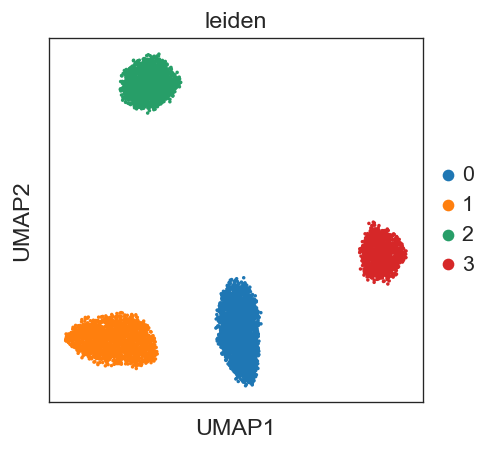

In [8]:
sc.tl.leiden(adata_psgl, resolution=0.1)
sc.pl.umap(adata_psgl, color=['leiden'])

(optional) In real case, you could first annotate the clusters with known cell-type markers before moving on. Here, as an example, we directly apply `TOMAS` to those clusters to showcase how to infer total-mRNA ratios with only scRNA-seq data.

Save identified cell cluters/types in `adata.obs` and perform DE analysis.

In [9]:
adata.obs['danno_RNAonly'] = 'unknown'
adata.obs.loc[adata_psgl.obs_names,'danno_RNAonly'] = adata_psgl.obs['leiden'].values
sc.tl.rank_genes_groups(adata_psgl, 'leiden', method='wilcoxon')
degene_sorted = tm.auxi.extract_specific_genes(adata_psgl, 'leiden')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)


## Hetero-doublets identification and refinement 

Identify hetero-dbls based on co-expression of marker genes of two cell types.

The naming convention of hetero-doublets is to use an underscore to connect the names of two constitutive cell types/clusters. (Underscore is not allowed in naming convention of pure cell types/clusters.)

Identify hetero-dbls composed by cluster '0' and cluster '1'

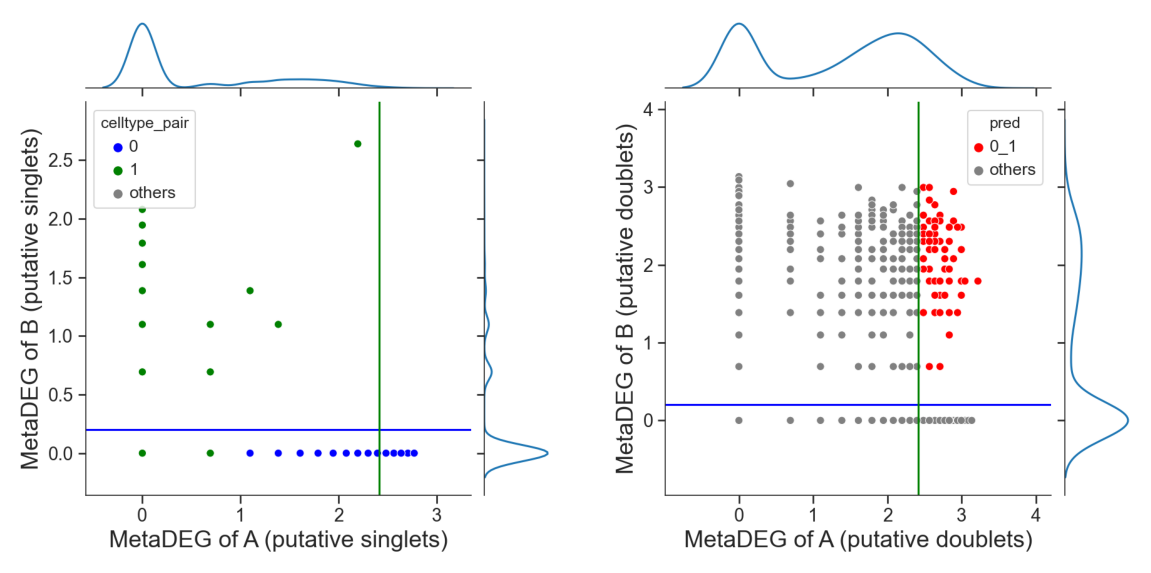

In [10]:
## try default parameters first
tm.infer.heteroDbl_bc(adata,
                      '0_1',
                      d_groupby = 'droplet_type',
                      ct_groupby = 'danno_RNAonly',
                      de_sorted = degene_sorted,
                      dpi=60)

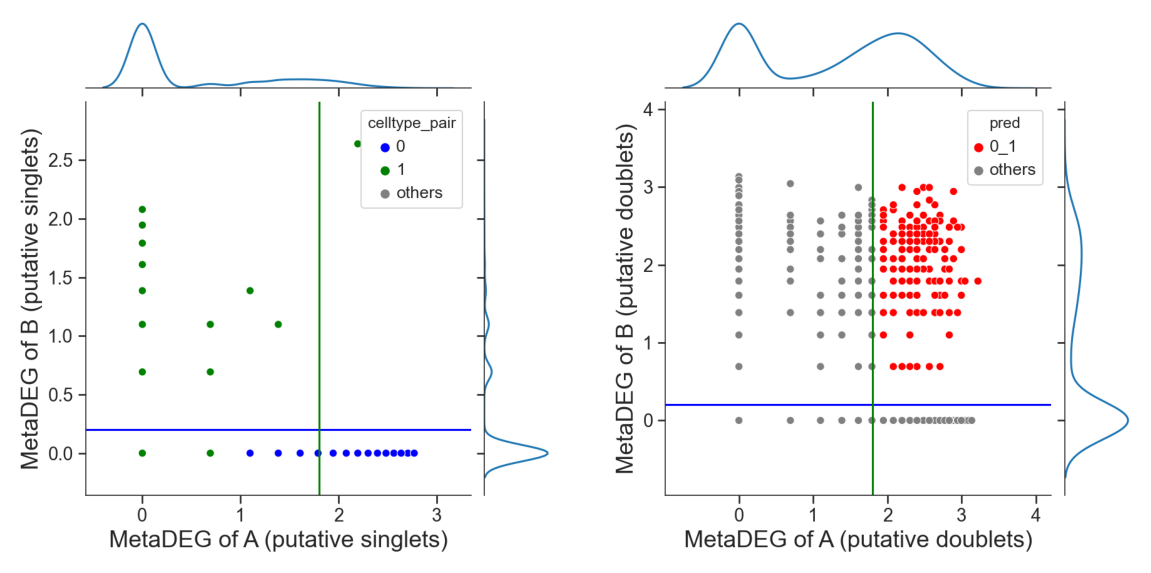

In [11]:
# adjust the cutoff by setting 'threshold_x', 'threshold_y' or 'threshold' if necessary
tm.infer.heteroDbl_bc(adata,
                      '0_1',
                      d_groupby = 'droplet_type',
                      ct_groupby = 'danno_RNAonly',
                      threshold_x = 1.8,
                      de_sorted = degene_sorted,
                      dpi=60)

Identify hetero-dbls composed by cluster '0' and cluster '2'

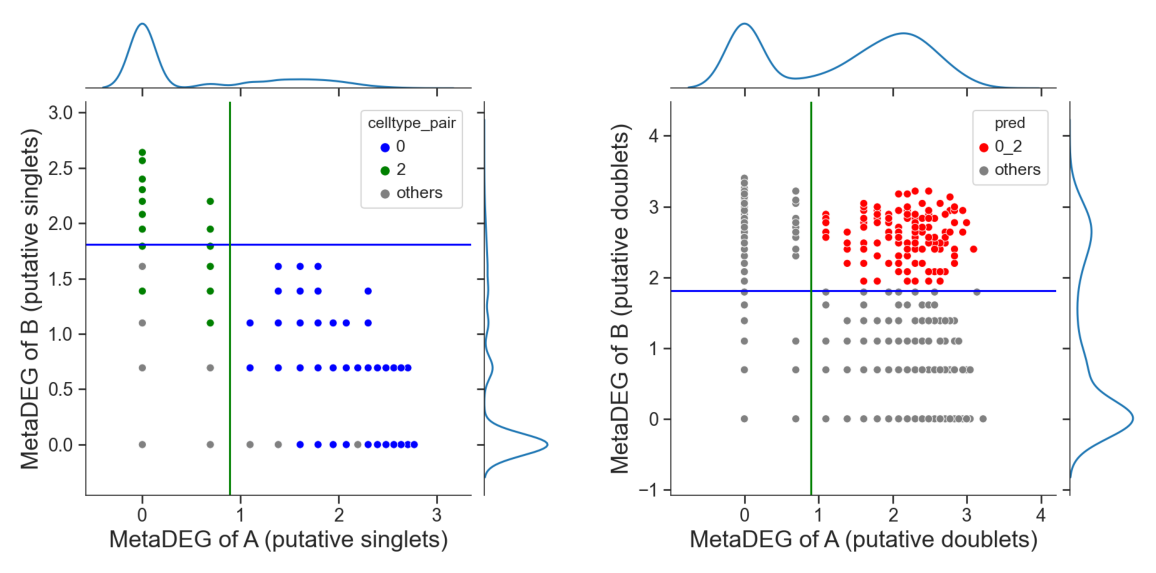

In [12]:
## try default parameters first
tm.infer.heteroDbl_bc(adata,
                      '0_2',
                      d_groupby = 'droplet_type',
                      ct_groupby = 'danno_RNAonly',
                      de_sorted = degene_sorted,
                      dpi=60)

Identify hetero-dbls composed by cluster '0' and cluster '3'

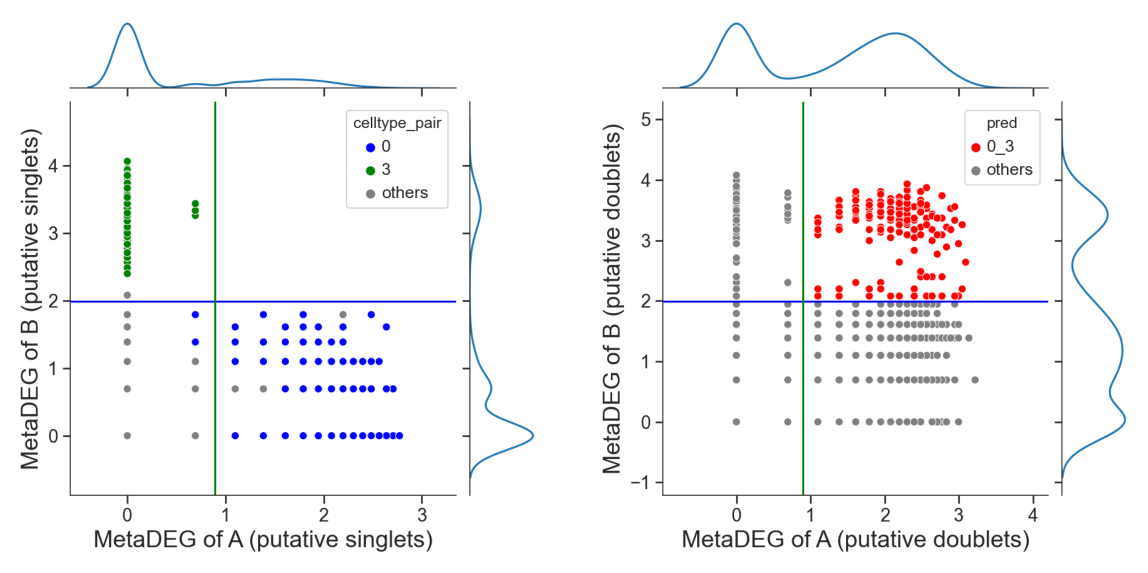

In [13]:
## try default parameters first
tm.infer.heteroDbl_bc(adata,
                      '0_3',
                      d_groupby = 'droplet_type',
                      ct_groupby = 'danno_RNAonly',
                      de_sorted = degene_sorted,
                      dpi=60)

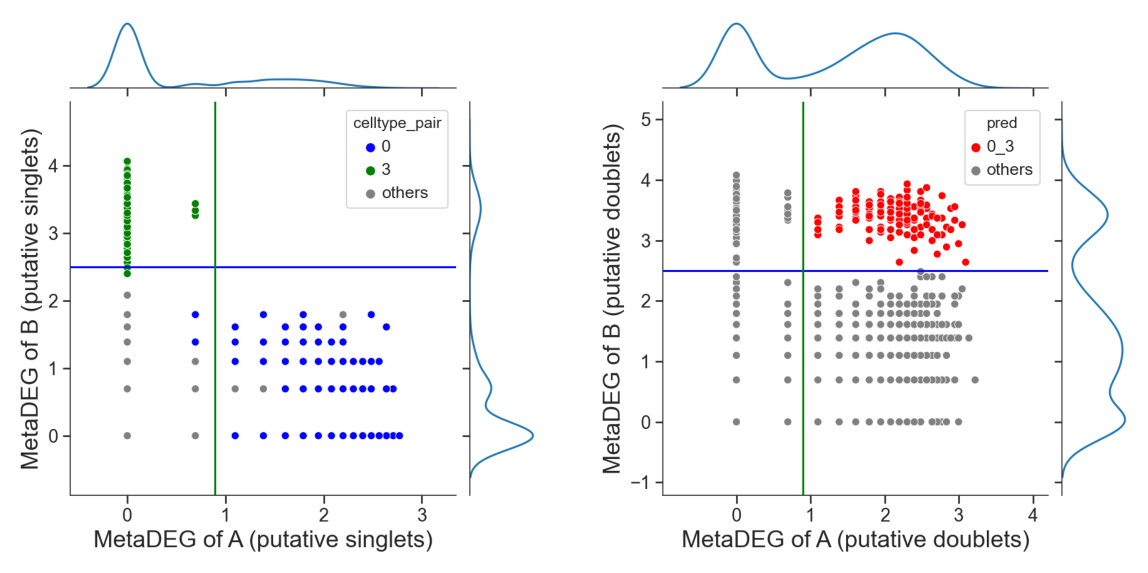

In [14]:
# adjust the cutoff by setting 'threshold_x', 'threshold_y' or 'threshold' if necessary
tm.infer.heteroDbl_bc(adata,
                      '0_3',
                      d_groupby = 'droplet_type',
                      ct_groupby = 'danno_RNAonly',
                      threshold_y = 2.5,
                      de_sorted = degene_sorted,
                      dpi=60)

Identify hetero-dbls composed by cluster '1' and cluster '2'

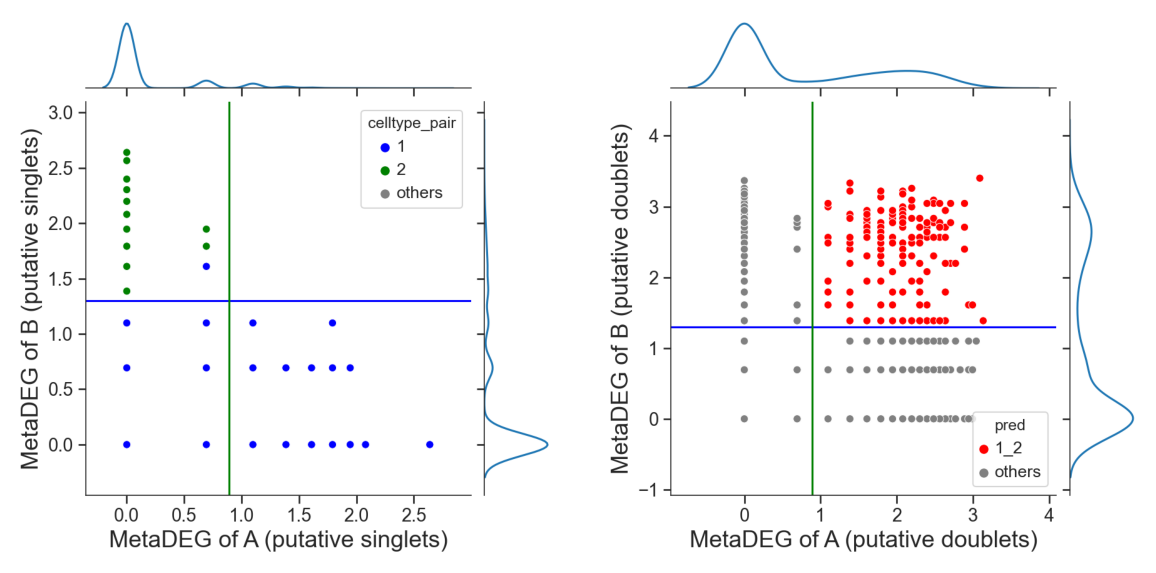

In [15]:
## try default parameters first
tm.infer.heteroDbl_bc(adata,
                      '1_2',
                      d_groupby = 'droplet_type',
                      ct_groupby = 'danno_RNAonly',
                      de_sorted = degene_sorted,
                      dpi=60)

Identify hetero-dbls composed by cluster '1' and cluster '3'

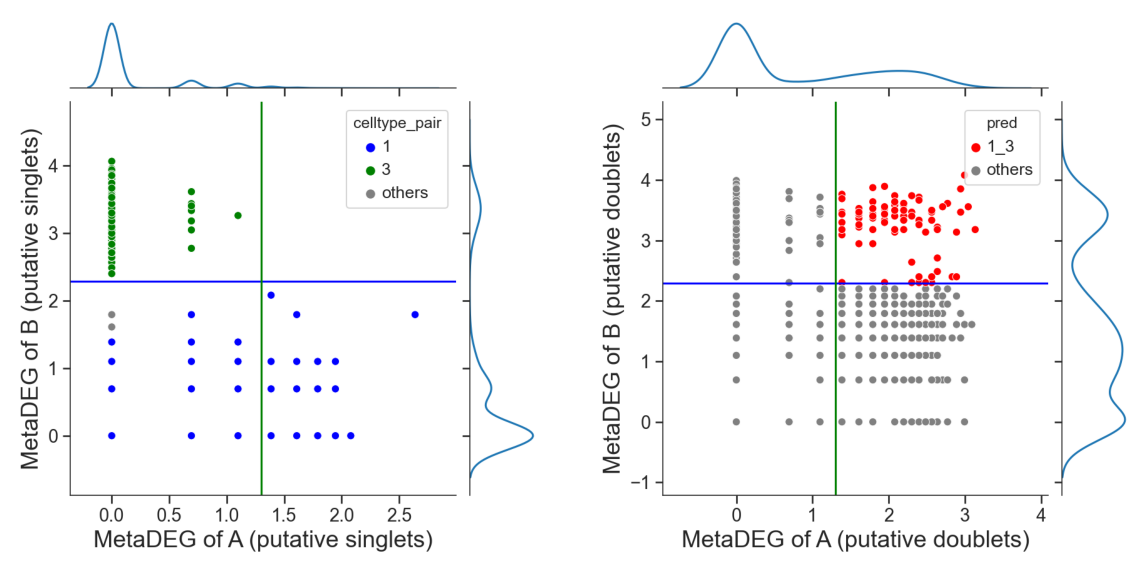

In [16]:
## try default parameters first
tm.infer.heteroDbl_bc(adata,
                      '1_3',
                      d_groupby = 'droplet_type',
                      ct_groupby = 'danno_RNAonly',
                      de_sorted = degene_sorted,
                      dpi=60)

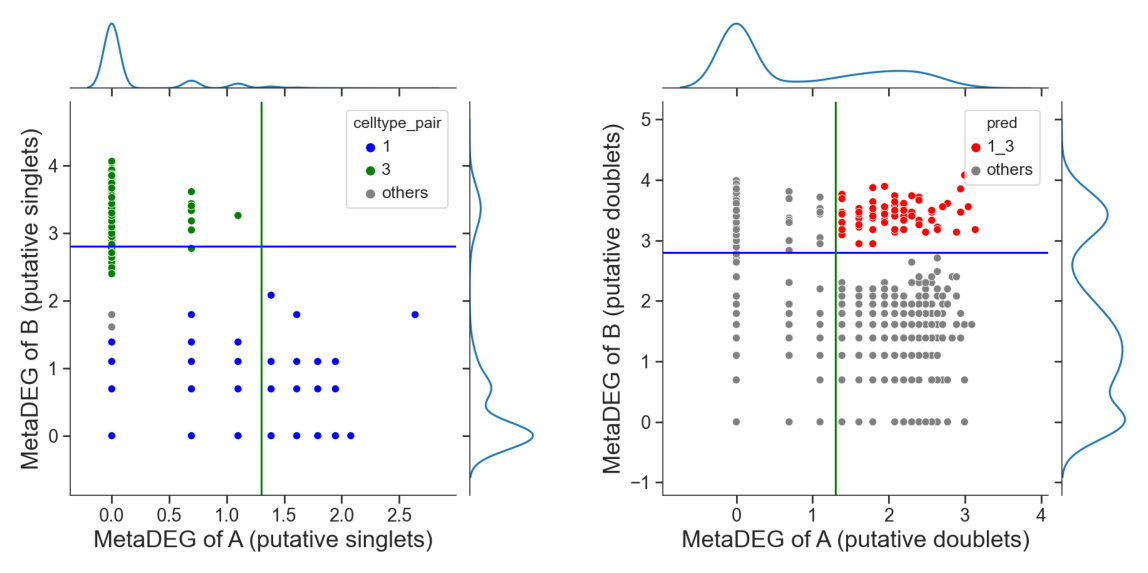

In [17]:
# adjust the cutoff by setting 'threshold_x', 'threshold_y' or 'threshold' if necessary
tm.infer.heteroDbl_bc(adata,
                      '1_3',
                      d_groupby = 'droplet_type',
                      ct_groupby = 'danno_RNAonly',
                      threshold_y = 2.8,
                      de_sorted = degene_sorted,
                      dpi=60)

Identify hetero-dbls composed by cluster '2' and cluster '3'

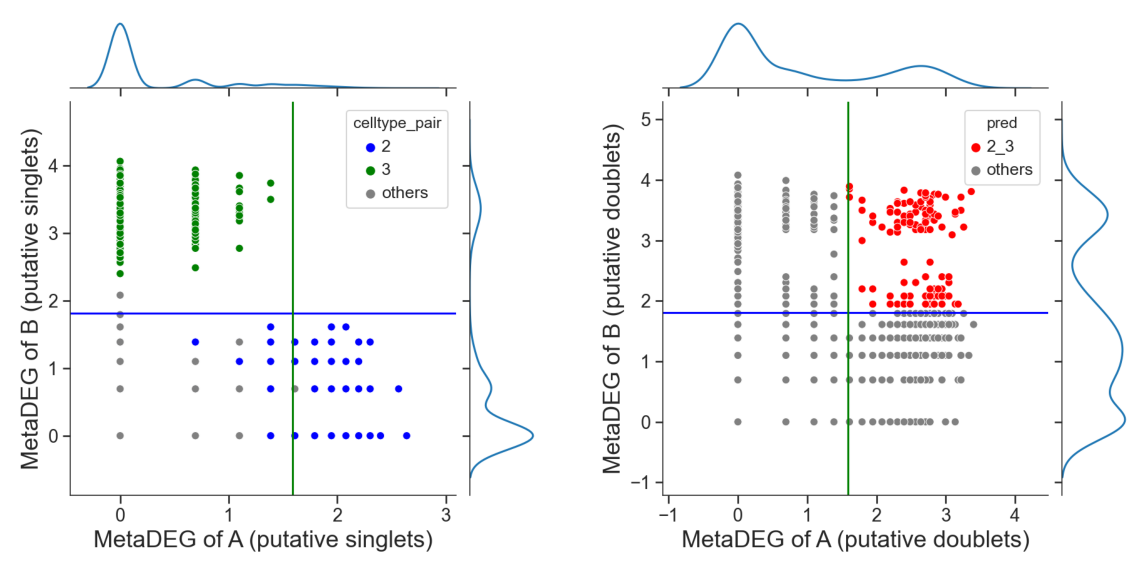

In [18]:
## try default parameters first
tm.infer.heteroDbl_bc(adata,
                      '2_3',
                      d_groupby = 'droplet_type',
                      ct_groupby = 'danno_RNAonly',
                      de_sorted = degene_sorted,
                      dpi=60)

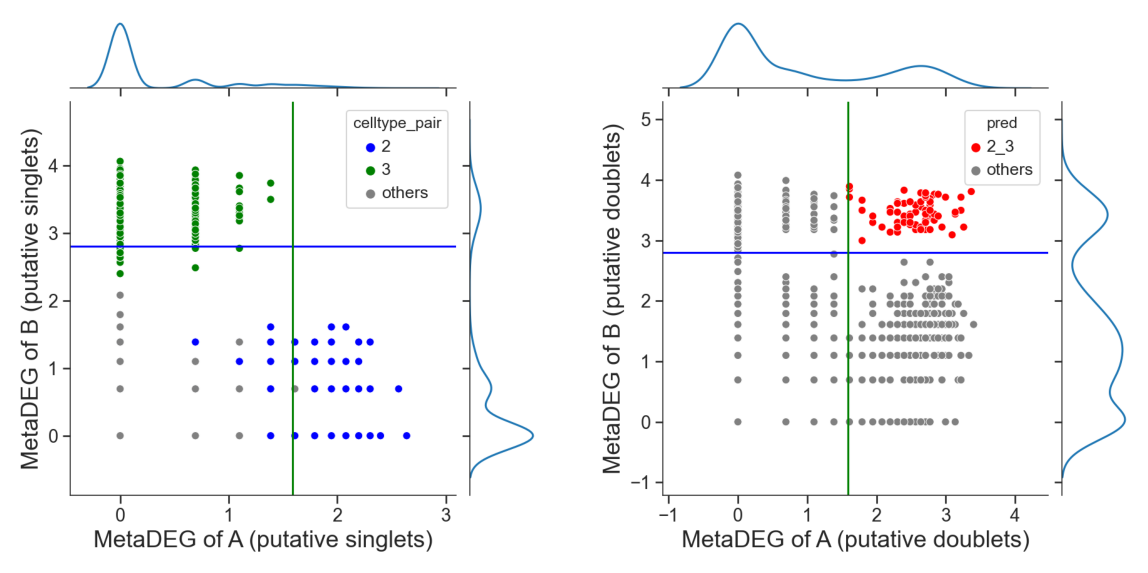

In [19]:
# adjust the cutoff by setting 'threshold_x', 'threshold_y' or 'threshold' if necessary
tm.infer.heteroDbl_bc(adata,
                      '2_3',
                      d_groupby = 'droplet_type',
                      ct_groupby = 'danno_RNAonly',
                      threshold_y = 2.8,
                      de_sorted = degene_sorted,
                      dpi=60)

Summarize droplet populations

In [20]:
tm.infer.heterodbl_summary(adata,ct_groupby='danno_RNAonly')

Counts of each kind of droplets:
        Hetero-dbl-type  counts
0                     0    2443
0_1                 0_1     159
0_2                 0_2     141
1                     1    1892
2                     2    1371
2_1                 2_1     120
3                     3    1094
3_0                 3_0     125
3_1                 3_1      65
3_2                 3_2      69
unknown         unknown     521


## Fit signature distribution for each cell type

In [21]:
tm.fit.logNormal(adata,groupby='danno_RNAonly')

tm.fit.dmn(adata,
           groupby='danno_RNAonly',
           groups=['0','1','2','3'],
           verbose=2,
           verbose_interval = 100)

Initialization 0
  Iteration 100	 time lapse 31.15464s	 ll change 0.01474
Initialization converged: True	 time lapse 53.09061s	 ll -22083.59051
3 is done!
Initialization 0
  Iteration 100	 time lapse 62.58861s	 ll change 0.03337
  Iteration 200	 time lapse 68.57251s	 ll change 0.00225
Initialization converged: True	 time lapse 166.77823s	 ll -22659.08424
1 is done!
Initialization 0
  Iteration 100	 time lapse 48.29173s	 ll change 0.06491
  Iteration 200	 time lapse 38.97226s	 ll change 0.00822
  Iteration 300	 time lapse 70.11431s	 ll change 0.00205
Initialization converged: True	 time lapse 186.56300s	 ll -20376.31360
2 is done!
Initialization 0
Initialization converged: True	 time lapse 63.20879s	 ll -20824.03802
0 is done!


In [22]:
adata_mgdic = tm.infer.get_dbl_mg(adata, groupby = 'danno_RNAonly') 

3_0
Initialized.
Iteration 2	time lapse 7.464699983596802s	ll change 986.740858053905

Iteration 4	time lapse 7.5402398109436035s	ll change 1.627344752108911

Iteration 6	time lapse 7.284444332122803s	ll change 0.19341495129629038

Iteration 8	time lapse 7.35881495475769s	ll change 0.22153924047597684



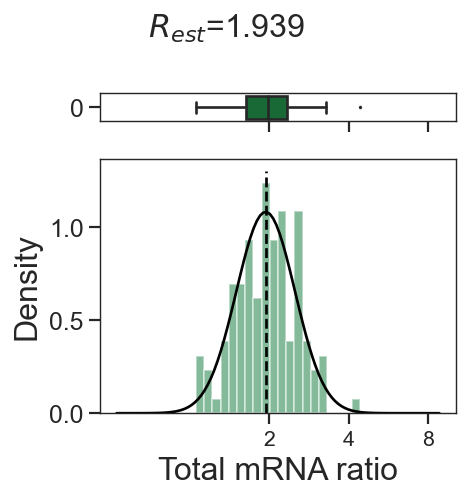

3_2
Initialized.
Iteration 2	time lapse 4.016129016876221s	ll change 501.9426881689724

Iteration 4	time lapse 3.8351340293884277s	ll change 0.6582975641649682

Iteration 6	time lapse 3.8424510955810547s	ll change 0.0386034477269277

Iteration 8	time lapse 3.987287998199463s	ll change 0.02481315698241815

Iteration 10	time lapse 4.088726997375488s	ll change 0.0035839457996189594



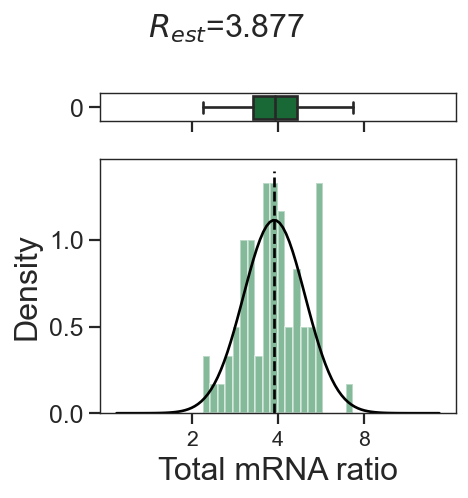

3_1
Initialized.
Iteration 2	time lapse 3.9632608890533447s	ll change 1085.2957540539064

Iteration 4	time lapse 3.7715671062469482s	ll change 2.7137881421658676

Iteration 6	time lapse 3.600537061691284s	ll change 0.011093866094597615

Iteration 8	time lapse 3.563723087310791s	ll change 0.0011783692752942443



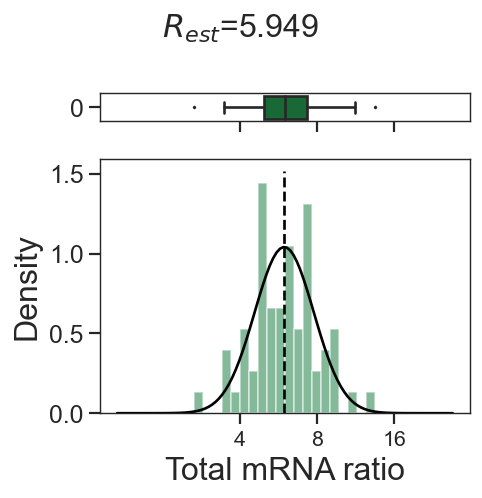

0_2
Initialized.
Iteration 2	time lapse 8.239360809326172s	ll change 2562.3200844880776

Iteration 4	time lapse 8.28295087814331s	ll change 0.3022694913961459

Iteration 6	time lapse 8.9981529712677s	ll change 0.09861751084099524

Iteration 8	time lapse 7.94610595703125s	ll change 0.025448093510931358

Iteration 10	time lapse 8.159227132797241s	ll change 0.0016252986679319292



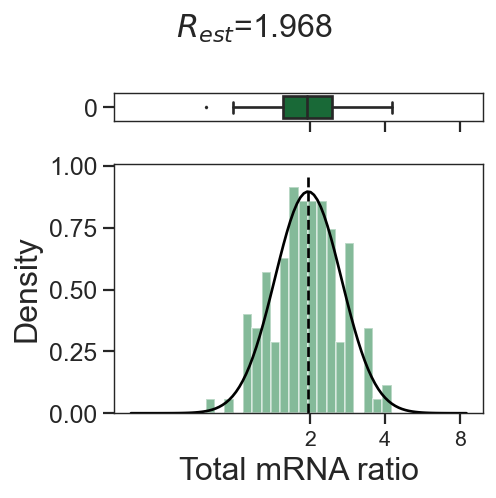

0_1
Initialized.
Iteration 2	time lapse 8.979889869689941s	ll change 3930.2558828322217

Iteration 4	time lapse 8.725122928619385s	ll change 5.201312209479511

Iteration 6	time lapse 8.938920974731445s	ll change 0.37982264140737243

Iteration 8	time lapse 8.75301194190979s	ll change 0.08157373909489252



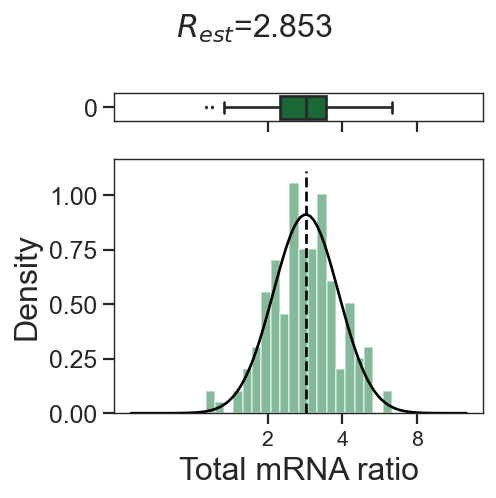

2_1
Initialized.
Iteration 2	time lapse 6.419339895248413s	ll change 7985.879368977185

Iteration 4	time lapse 6.3484368324279785s	ll change 7.526343683304731

Iteration 6	time lapse 6.2439188957214355s	ll change 3.0303274058387615

Iteration 8	time lapse 6.381319999694824s	ll change 0.15699274133658037

Iteration 10	time lapse 6.293601989746094s	ll change 3.559465659491252

Iteration 12	time lapse 6.3302342891693115s	ll change 0.0681253346556332

Iteration 14	time lapse 6.408145189285278s	ll change 0.48068093752954155

Iteration 16	time lapse 6.477036952972412s	ll change 0.0



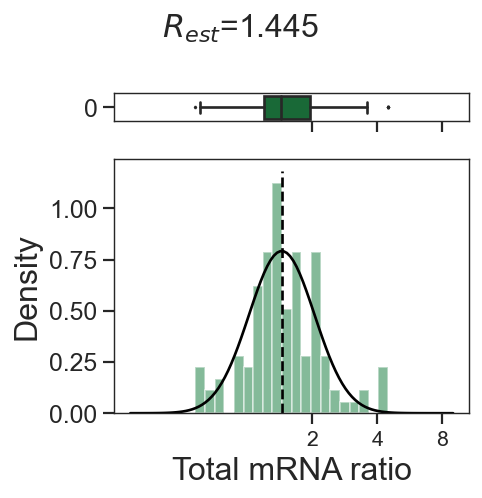

In [23]:
for dbl in adata_mgdic:
    print(dbl)
    
    tm.infer.ratios_bc(adata_mgdic[dbl],dbl,verbose=1)
    w_best = adata_mgdic[dbl].uns['ratio']['w_best']
    tm.vis.logRatio_dist((1-w_best)/w_best)

## Compare with simulation ground truth

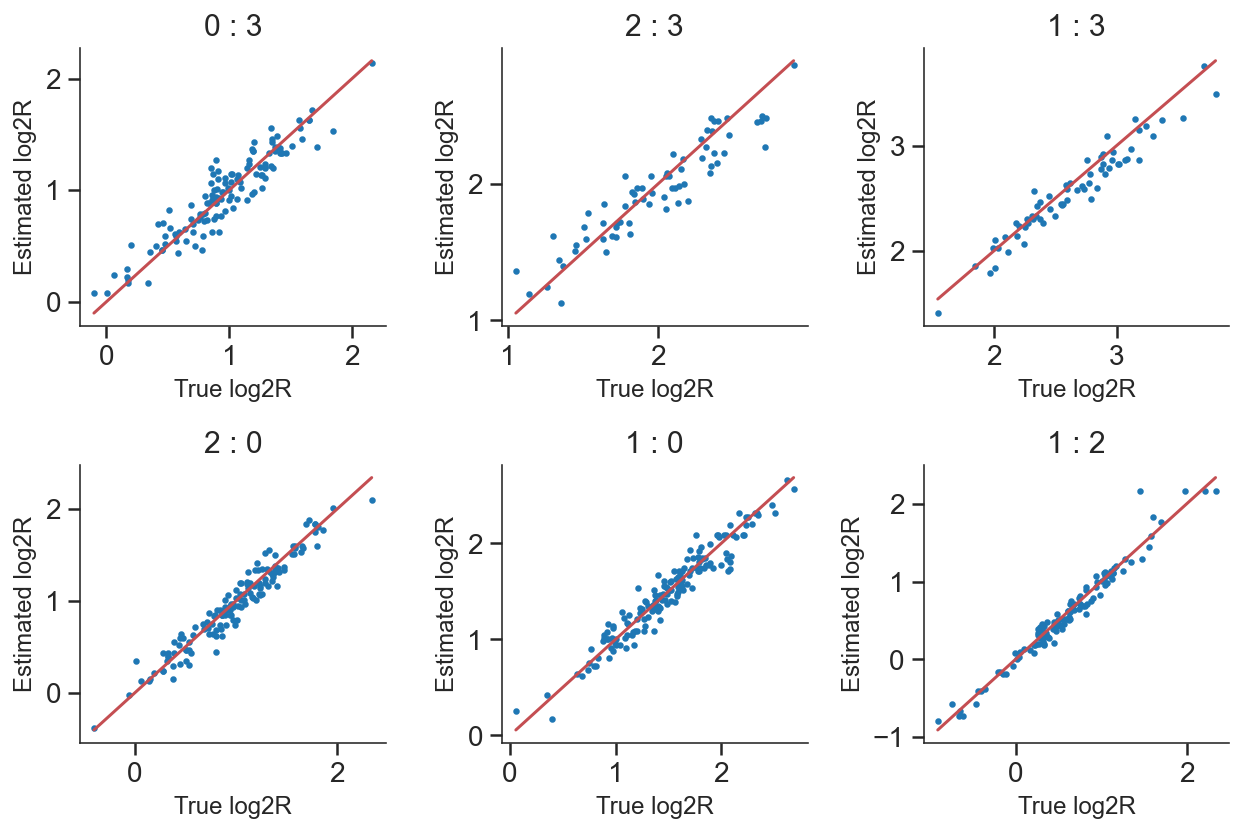

In [25]:
from matplotlib import pyplot as plt

dbl_groups = list(adata_mgdic.keys())

plt.figure(figsize=(9,3*np.ceil(len(dbl_groups) / 3)), dpi=72)
for i in range(len(dbl_groups)):
    ax = plt.subplot(int(np.ceil(len(dbl_groups)/3)),3,i+1)
    
    dbl = dbl_groups[i]

    log2R_true = np.log2(adata.obs.loc[adata.obs['danno_RNAonly']==dbl,'trueR'])
    w_best = adata_mgdic[dbl].uns['ratio']['w_best']
    log2R_pred = np.log2((1-w_best)/w_best)

    plt.scatter(log2R_true, log2R_pred,s=5)
    plt.plot([np.min(log2R_true),np.max(log2R_true)],[np.min(log2R_true),np.max(log2R_true)],c='r')

    plt.xlabel('True log2R',fontsize=12)
    plt.ylabel('Estimated log2R',fontsize=12)
    plt.title(dbl.split('_')[1]+' : '+dbl.split('_')[0],fontsize=15)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')

plt.tight_layout()
plt.show()

Save estimated ratios in AnnData object of the whole dataset

In [26]:
tm.infer.save_ratio_in_anndata(adata_mgdic, adata)

In [27]:
adata.write('../../datasets/adata_mRNAonly_tomas.h5ad')